# Boulder 2016 Bike Share Multi-Class Classification Modeling

## 1. Introduction

The data exploration performed on the Boulder Trips dataset indicates weather variables have a significant impact on the number of checkouts. This section will focus on investigating the use of various classification models on the Trips data when combined with weather variables.

In [1]:
# Import necessary libraries and functions that are needed for the modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn import linear_model, naive_bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import ShuffleSplit, train_test_split, cross_val_score
from sklearn import metrics
import seaborn as sns
from timeit import default_timer as timer
from imblearn.over_sampling import RandomOverSampler
%matplotlib inline

In [2]:
# taken from Brandon Rhodes's Pandas Tutorial (https://github.com/brandon-rhodes)
from IPython.core.display import HTML
css = open('data/style-table.css').read() + open('data/style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [3]:
dF = pd.read_csv("data/2016_Boulder_Bike_Trip_ML_Data.gz", dtype = {'Bike_Number' : object}, compression="gzip")

In [4]:
dF.shape

(98270, 13)

In [5]:
dF.head(1)

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Hour,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration,Checkout_WeekDay,Checkout_Month
0,Boulder B-cycle,R1073079,Semester (150-day),516,2016-01-01,0,15th & Pearl,2016-01-01,01:10:00,UCAR Mitchell Lane,22,4,1


In [6]:
dF.drop(['User_Program'], axis = 1, inplace = True)
dF.drop(['Membership_Type'], axis = 1, inplace = True)
dF.drop(['User_ID'], axis = 1, inplace = True)
dF.drop(['Bike_Number'], axis = 1, inplace = True)
dF.drop(['Checkout_Kiosk'], axis = 1, inplace = True)
dF.drop(['Return_Date'], axis = 1, inplace = True)
dF.drop(['Return_Kiosk'], axis = 1, inplace = True)
dF.drop(['Return_Time'], axis = 1, inplace = True)
dF.drop(['Trip_Duration'], axis = 1, inplace = True)
#dF.drop(['Trip_Distance'], axis = 1, inplace = True)

In [7]:
dF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98270 entries, 0 to 98269
Data columns (total 4 columns):
Checkout_Date       98270 non-null object
Checkout_Hour       98270 non-null int64
Checkout_WeekDay    98270 non-null int64
Checkout_Month      98270 non-null int64
dtypes: int64(3), object(1)
memory usage: 3.0+ MB


In [8]:
# re-arrange columns in preparation for training and test data
dF = dF[['Checkout_Date', 'Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour']]

In [9]:
dF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98270 entries, 0 to 98269
Data columns (total 4 columns):
Checkout_Date       98270 non-null object
Checkout_Month      98270 non-null int64
Checkout_WeekDay    98270 non-null int64
Checkout_Hour       98270 non-null int64
dtypes: int64(3), object(1)
memory usage: 3.0+ MB


In [10]:
# Load the 2016 Weather data into a dataframe
dW = pd.read_csv("data/Boulder_2016_Hourly_Weather_Forecast.csv")

In [11]:
dW.rename(columns = {'Hour': 'Checkout_Hour'}, inplace = True)

In [12]:
dW['Checkout_WeekDay'] = pd.DatetimeIndex(dW['Date']).weekday

In [13]:
dW['Checkout_Month'] = pd.DatetimeIndex(dW['Date']).month

In [14]:
dFW = dF.groupby(['Checkout_Date', 'Checkout_Month', 'Checkout_WeekDay', 
                  'Checkout_Hour']).size().to_frame(name = 'Number_Of_Checkouts').reset_index()

In [15]:
dT = pd.merge(dW, dFW, how='left', left_on=['Date', 'Checkout_Hour'], 
              right_on=['Checkout_Date', 'Checkout_Hour'])

In [16]:
dT.isnull().values.any()

True

In [17]:
nan_rows = dT[dT.isnull().T.any().T]

In [18]:
dT = dT.drop(dT.index[nan_rows.index])

In [19]:
dT.isnull().values.any()

False

In [20]:
dT.drop(['Date', 'Checkout_WeekDay_y', 'Checkout_Month_y'], axis = 1, inplace = True)
dT.rename(columns = {'cloudCover': 'Cloud_Cover', 'temperature': 'Temperature', 'apparentTemperature' : 'Apparent_Temperature',
                     'windSpeed' : 'Wind_Speed', 'humidity' : 'Humidity', 'visibility' : 'Visibility',
                     'Checkout_WeekDay_x': 'Checkout_WeekDay', 'Checkout_Month_x': 'Checkout_Month'}, inplace = True)

In [21]:
#dT = dT[~((dT.Checkout_Hour == 0)  | (dT.Checkout_Hour == 1)  | (dT.Checkout_Hour == 2)  | (dT.Checkout_Hour == 3)  |
         #(dT.Checkout_Hour == 4))]

In [22]:
dT.shape

(7056, 11)

In [23]:
dT['Number_Of_Checkouts'].max()

113.0

In [24]:
dT.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7056 entries, 0 to 8758
Data columns (total 11 columns):
Checkout_Hour           7056 non-null int64
Apparent_Temperature    7056 non-null float64
Cloud_Cover             7056 non-null float64
Humidity                7056 non-null float64
Temperature             7056 non-null float64
Visibility              7056 non-null float64
Wind_Speed              7056 non-null float64
Checkout_WeekDay        7056 non-null int32
Checkout_Month          7056 non-null int32
Checkout_Date           7056 non-null object
Number_Of_Checkouts     7056 non-null float64
dtypes: float64(7), int32(2), int64(1), object(1)
memory usage: 606.4+ KB


In [25]:
dT.rename(columns = {'cloudCover': 'Cloud_Cover', 'temperature': 'Temperature', 'apparentTemperature' : 'Apparent_Temperature',
                     'windSpeed' : 'Wind_Speed', 'humidity' : 'Humidity', 'visibility' : 'Visibility'}, inplace = True)

In [26]:
dT = dT[['Checkout_Date', 'Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour', 'Temperature', 'Apparent_Temperature',
             'Cloud_Cover', 'Humidity', 'Wind_Speed', 'Visibility', 'Number_Of_Checkouts']]

### Convert the numeric Calendar and Clock columns into categorical columns

In [27]:
month_dummies = pd.get_dummies(dT.Checkout_Month, prefix='month')

In [28]:
weekday_dummies = pd.get_dummies(dT.Checkout_WeekDay, prefix='weekday')

In [29]:
hour_dummies = pd.get_dummies(dT.Checkout_Hour, prefix='hour')

In [30]:
data = pd.concat([dT, month_dummies, weekday_dummies, hour_dummies], axis=1)

In [31]:
data = data[['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour',
             'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
             'month_9', 'month_10', 'month_11', 'month_12',
             'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
             'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
             'hour_14', 'hour_15', 'hour_16', 'hour_17',
             'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
             'Temperature', 'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility',
             'Number_Of_Checkouts']]

In [32]:
data['Number_Of_Checkouts'] = data[['Number_Of_Checkouts']].astype('int32')

### Create a Class_Label column for a 2-class classification 

In [33]:
data['Class_Label'] = data['Number_Of_Checkouts'].map(lambda x: 0 if ((x >= 1) & (x <= 10)) 
                                                 else 1)

In [34]:
data.head()

,Checkout_Month,Checkout_WeekDay,Checkout_Hour,month_1,month_2,month_3,month_4,month_5,month_6,month_7,...,hour_22,hour_23,Temperature,Apparent_Temperature,Cloud_Cover,Wind_Speed,Humidity,Visibility,Number_Of_Checkouts,Class_Label
0,1,4,0,1,0,0,0,0,0,0,...,0,0,7.52,0.65,0.01,3.50,0.83,7.75,1,0
4,1,4,4,1,0,0,0,0,0,0,...,0,0,5.37,-2.51,0.00,3.90,0.81,9.61,1,0
9,1,4,9,1,0,0,0,0,0,0,...,0,0,14.37,6.74,0.02,4.70,0.65,10.00,1,0
10,1,4,10,1,0,0,0,0,0,0,...,0,0,19.58,9.90,0.07,7.76,0.56,10.00,3,0
11,1,4,11,1,0,0,0,0,0,0,...,0,0,26.07,21.94,0.07,3.45,0.40,10.00,4,0


In [35]:
dd = data.groupby(data.Number_Of_Checkouts).size()
dd

Number_Of_Checkouts
1      843
2      529
3      428
4      339
5      268
6      257
7      228
8      235
9      205
10     200
11     182
12     208
13     178
14     176
15     162
16     144
17     159
18     157
19     140
20     132
21     139
22     125
23     124
24     124
25     114
26     113
27      99
28      72
29      90
30      73
      ... 
40      31
41      29
42      30
43      18
44      28
45      13
46      18
47      13
48      12
49      10
50       9
51      10
52       7
53       8
54       7
55       8
56       5
57       6
58       1
59       2
60       3
61       1
62       1
63       1
66       1
67       1
68       2
74       1
76       1
113      1
dtype: int64

In [36]:
dd = data.groupby(data.Class_Label).size()
dd

Class_Label
0    3532
1    3524
dtype: int64

### Keep 10 samples aside for use in prediction on unseen samples

In [37]:
dUT = data.sample(n=10, random_state=123)

In [38]:
del_rows = dUT.index

In [39]:
data.drop(del_rows, axis=0, inplace=True)

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7046 entries, 0 to 8758
Data columns (total 49 columns):
Checkout_Month          7046 non-null int32
Checkout_WeekDay        7046 non-null int32
Checkout_Hour           7046 non-null int64
month_1                 7046 non-null uint8
month_2                 7046 non-null uint8
month_3                 7046 non-null uint8
month_4                 7046 non-null uint8
month_5                 7046 non-null uint8
month_6                 7046 non-null uint8
month_7                 7046 non-null uint8
month_8                 7046 non-null uint8
month_9                 7046 non-null uint8
month_10                7046 non-null uint8
month_11                7046 non-null uint8
month_12                7046 non-null uint8
weekday_0               7046 non-null uint8
weekday_1               7046 non-null uint8
weekday_2               7046 non-null uint8
weekday_3               7046 non-null uint8
weekday_4               7046 non-null uint8
weekday_5    

In [41]:
data = data[['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour',
             'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
             'month_9', 'month_10', 'month_11', 'month_12',
             'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
             'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
             'hour_14', 'hour_15', 'hour_16', 'hour_17',
             'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
             'Temperature', 'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility',
             'Class_Label']]

In [42]:
array = data.values

In [43]:
X = array[:,3:47]
X[0]

array([ 1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  7.52,  0.65,  0.01,  3.5 ,  0.83,  7.75])

In [44]:
y = array[:,47]
y[0]

0.0

## Feature Correlations

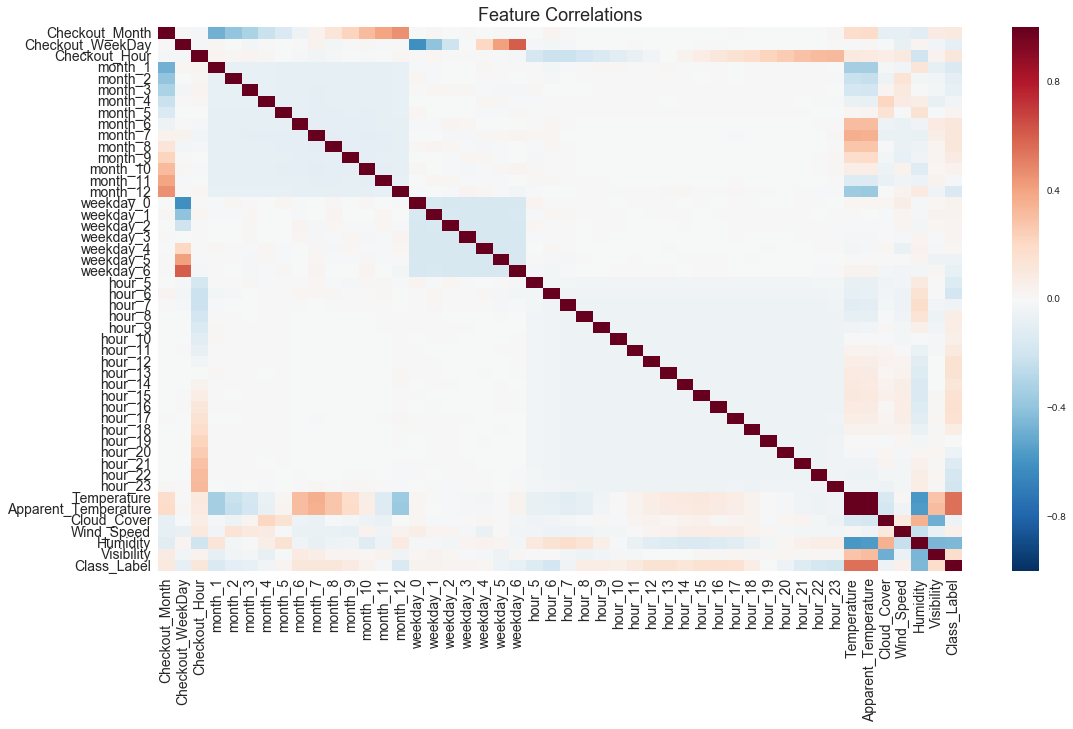

In [45]:
plt.figure(figsize=(18,10))
ax = sns.heatmap(data.corr())
plt.title("Feature Correlations", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [46]:
features = ['month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
             'month_9', 'month_10', 'month_11', 'month_12',
             'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
             'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
             'hour_14', 'hour_15', 'hour_16', 'hour_17',
             'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
             'Temperature', 'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility']
X = data[features]
y = data["Class_Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

## 2. Modeling - Categorical Feature Set

In [47]:
def plot_feature_importances(model, plot_title):
    n_features = X.shape[1]
    plt.figure(figsize=(10,14))
    feature_importance = model.feature_importances_
    features_list = features
    feature_importance, features_list = zip(*sorted(zip(feature_importance, features_list)))
    plt.barh(range(len(features_list)), feature_importance, align='center')
    plt.xticks(fontsize=14)
    plt.yticks(np.arange(len(features_list)), features_list, fontsize=14)
    plt.xlabel('Relative Importance', fontsize=16)
    plt.ylabel('Feature', fontsize=16)
    plt.title(plot_title + ' Features Importance', fontsize=20)
    plt.show()

In [48]:
def get_class_metrics(model, actual, predicted):
    class_metrics = {'Accuracy' : metrics.accuracy_score(actual, predicted),
                         'F1 (macro)' : metrics.f1_score(actual, predicted, average='macro'),
                         'F1 (micro)' : metrics.f1_score(actual, predicted, average='micro'),
                         'Precision (macro)' : metrics.precision_score(actual, predicted,  average='macro'),
                         'Precision (micro)' : metrics.precision_score(actual, predicted,  average='micro'),
                         'Recall (macro)' : metrics.recall_score(actual, predicted,  average='macro'),
                         'Recall (micro)' : metrics.recall_score(actual, predicted,  average='micro')}
    dML_metrics = pd.DataFrame.from_dict(class_metrics, orient='index')
    dML_metrics.columns = [model]
    return dML_metrics

In [49]:
def perform_classification(model, clfr):   
 
    clfr.fit(X_train, y_train)
    ypred = clfr.predict(X_test)
    got_metrics = get_class_metrics(model, y_test, ypred)
    print(model,'\n')
    print("Accuracy on training set: {:.3f}".format(clfr.score(X_train, y_train)))
    print("Accuracy on test set: {:.3f}".format(clfr.score(X_test, y_test)))
    print('\nConfusion Matrix:')
    print(metrics.confusion_matrix(y_test, ypred))
    print('\nClassification Report:')
    print(metrics.classification_report(y_test, ypred))
    return got_metrics

In [50]:
from sklearn.model_selection import StratifiedShuffleSplit
def perform_cross_validation(model, clfr):
    shuffle_split = StratifiedShuffleSplit(test_size=.5, train_size=.5, n_splits=5)
    scores = cross_val_score(clfr, X, y, cv=shuffle_split)
    print("Cross-validation scores:\n{}".format(scores))
    print("Cross-validation accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2) + " @ 95% CI")
    #print("Cross-validation scores mean: {:.3f}".format(scores.mean()))
    xv_metrics = {'Cross Validation' : scores.mean()}
    dXV_metrics = pd.DataFrame.from_dict(xv_metrics, orient='index')
    dXV_metrics.columns = [model]
    return dXV_metrics

In [51]:
def get_execution_time_metrics(model, et):
    et_metrics = {'Execution Time (sec)' : et}
    dET_metrics = pd.DataFrame.from_dict(et_metrics, orient='index')
    dET_metrics.columns = [model]
    return dET_metrics

#### Decision Tree Classification

Decision Tree Classification 

Accuracy on training set: 1.000
Accuracy on test set: 0.811

Confusion Matrix:
[[867 191]
 [208 848]]

Classification Report:
             precision    recall  f1-score   support

          0       0.81      0.82      0.81      1058
          1       0.82      0.80      0.81      1056

avg / total       0.81      0.81      0.81      2114

Cross-validation scores:
[ 0.79534488  0.8030088   0.79165484  0.81464661  0.81663355]
Cross-validation accuracy: 0.80 (+/- 0.02) @ 95% CI

Execution Time (sec): 0.317


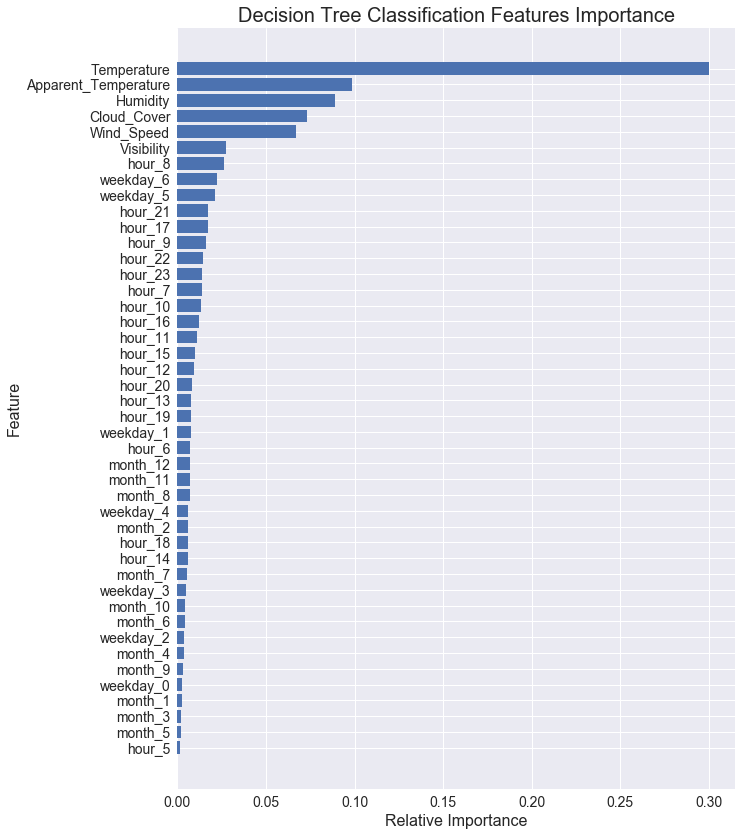

,Decision Tree Classification
Accuracy,0.811258
F1 (macro),0.811243
F1 (micro),0.811258
Precision (macro),0.811341
Precision (micro),0.811258
Recall (macro),0.811251
Recall (micro),0.811258


In [52]:
# Decision Tree Classifier
class_model = 'Decision Tree Classification'
start = timer()
clf = DecisionTreeClassifier(random_state=0)
dtc = perform_classification(class_model, clf)
dtc_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format(et))
dtc_et = get_execution_time_metrics(class_model, et)
plot_feature_importances(clf, class_model)
dtc.sort_index()

#### Linear (Logistic) Classification

In [53]:
# logistic regression
class_model = 'Logistic Classification'
start = timer()
#clf = linear_model.LogisticRegression(random_state=0)
clf = linear_model.LogisticRegression(C=1.0, solver='lbfgs', random_state=0, multi_class='ovr', n_jobs=-1)
lin_reg = perform_classification(class_model, clf)
lin_reg_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format((end - start)))
lin_reg_et = get_execution_time_metrics(class_model, et)
lin_reg.sort_index()

Logistic Classification 

Accuracy on training set: 0.868
Accuracy on test set: 0.877

Confusion Matrix:
[[924 134]
 [126 930]]

Classification Report:
             precision    recall  f1-score   support

          0       0.88      0.87      0.88      1058
          1       0.87      0.88      0.88      1056

avg / total       0.88      0.88      0.88      2114

Cross-validation scores:
[ 0.85126313  0.86176554  0.85353392  0.86829407  0.85835935]
Cross-validation accuracy: 0.86 (+/- 0.01) @ 95% CI

Execution Time (sec): 10.792


,Logistic Classification
Accuracy,0.877010
F1 (macro),0.877009
F1 (micro),0.877010
Precision (macro),0.877030
Precision (micro),0.877010
Recall (macro),0.877014
Recall (micro),0.877010


#### Random Forest Classification

Random Forest Classification 

Accuracy on training set: 1.000
Accuracy on test set: 0.856

Confusion Matrix:
[[934 124]
 [180 876]]

Classification Report:
             precision    recall  f1-score   support

          0       0.84      0.88      0.86      1058
          1       0.88      0.83      0.85      1056

avg / total       0.86      0.86      0.86      2114

Cross-validation scores:
[ 0.85750781  0.85949475  0.84984388  0.85211467  0.86176554]
Cross-validation accuracy: 0.86 (+/- 0.01) @ 95% CI

Execution Time (sec): 4.023


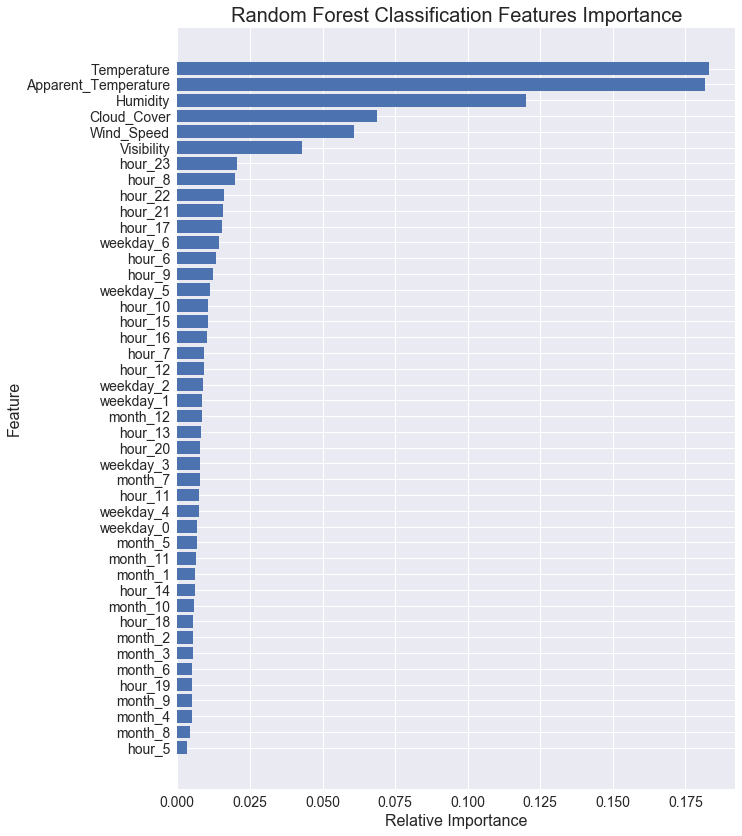

,Random Forest Classification
Accuracy,0.856197
F1 (macro),0.856088
F1 (micro),0.856197
Precision (macro),0.857210
Precision (micro),0.856197
Recall (macro),0.856172
Recall (micro),0.856197


In [54]:
# Random Forest Classifier
class_model = 'Random Forest Classification'
start = timer() 
clf = RandomForestClassifier(n_estimators=150, max_features='auto', max_depth=None, random_state=0, n_jobs=-1)
rfc = perform_classification(class_model, clf)
rfc_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format((end - start)))
rfc_et = get_execution_time_metrics(class_model, et)
plot_feature_importances(clf, class_model)
rfc.sort_index()

#### Extra Trees Classification

Extra Trees Classification 

Accuracy on training set: 1.000
Accuracy on test set: 0.877

Confusion Matrix:
[[945 113]
 [147 909]]

Classification Report:
             precision    recall  f1-score   support

          0       0.87      0.89      0.88      1058
          1       0.89      0.86      0.87      1056

avg / total       0.88      0.88      0.88      2114

Cross-validation scores:
[ 0.87226795  0.86488788  0.86545558  0.86801022  0.86460403]
Cross-validation accuracy: 0.87 (+/- 0.01) @ 95% CI

Execution Time (sec): 3.426


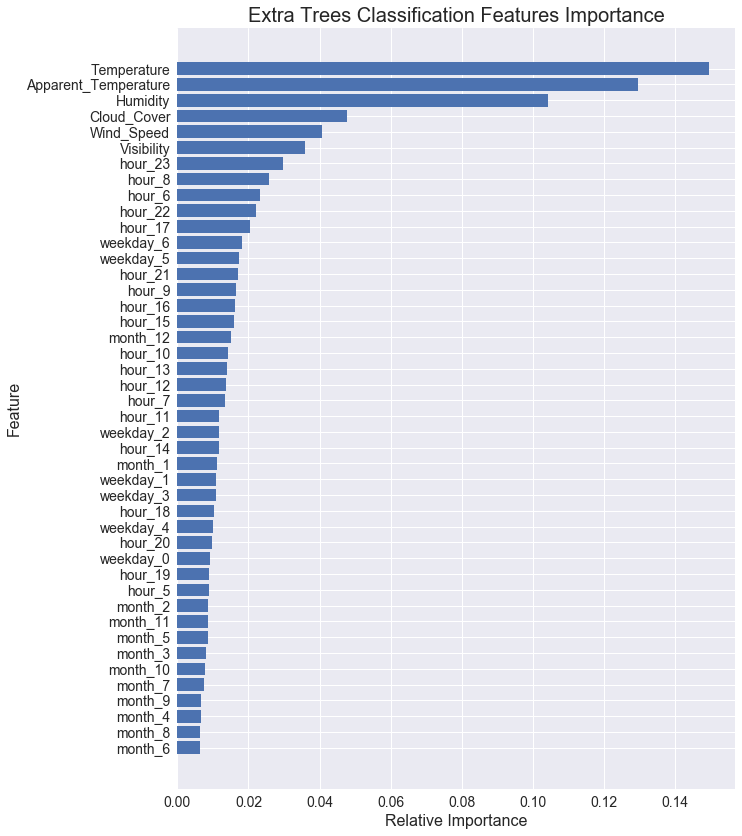

,Extra Trees Classification
Accuracy,0.877010
F1 (macro),0.876975
F1 (micro),0.877010
Precision (macro),0.877409
Precision (micro),0.877010
Recall (macro),0.876995
Recall (micro),0.877010


In [55]:
# Extra Trees Classifier
class_model = 'Extra Trees Classification'
start = timer() 
clf = ExtraTreesClassifier(n_estimators=150, max_features='auto', max_depth=None, random_state=0, n_jobs=-1)
etc = perform_classification(class_model, clf)
etc_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format((end - start)))
etc_et = get_execution_time_metrics(class_model, et)
plot_feature_importances(clf, class_model)
etc.sort_index()

#### Naive Bayes Classification

In [56]:
# Naive Bayes Classifier
class_model = 'Naive Bayes Classification'
start = timer()
clf = naive_bayes.GaussianNB()
nbg = perform_classification(class_model, clf)
nbg_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format((end - start)))
nbg_et = get_execution_time_metrics(class_model, et)
nbg.sort_index()

Naive Bayes Classification 

Accuracy on training set: 0.750
Accuracy on test set: 0.756

Confusion Matrix:
[[ 599  459]
 [  56 1000]]

Classification Report:
             precision    recall  f1-score   support

          0       0.91      0.57      0.70      1058
          1       0.69      0.95      0.80      1056

avg / total       0.80      0.76      0.75      2114

Cross-validation scores:
[ 0.75134828  0.75276753  0.72267953  0.76270224  0.71331252]
Cross-validation accuracy: 0.74 (+/- 0.04) @ 95% CI

Execution Time (sec): 0.175


,Naive Bayes Classification
Accuracy,0.756386
F1 (macro),0.747293
F1 (micro),0.756386
Precision (macro),0.799952
Precision (micro),0.756386
Recall (macro),0.756566
Recall (micro),0.756386


#### Nearest Neighbors Classification

In [57]:
# Nearest Neighbors Classifier
class_model = 'Nearest Neighbors Classification'
start = timer()
clf = KNeighborsClassifier(n_neighbors=2, n_jobs=-1)
knn = perform_classification(class_model, clf)
knn_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format((end - start)))
knn_et = get_execution_time_metrics(class_model, et)
knn.sort_index()

Nearest Neighbors Classification 

Accuracy on training set: 0.855
Accuracy on test set: 0.714

Confusion Matrix:
[[960  98]
 [506 550]]

Classification Report:
             precision    recall  f1-score   support

          0       0.65      0.91      0.76      1058
          1       0.85      0.52      0.65      1056

avg / total       0.75      0.71      0.70      2114

Cross-validation scores:
[ 0.72551802  0.70877093  0.72381493  0.72920806  0.72211184]
Cross-validation accuracy: 0.72 (+/- 0.01) @ 95% CI

Execution Time (sec): 0.995


,Nearest Neighbors Classification
Accuracy,0.714286
F1 (macro),0.703119
F1 (micro),0.714286
Precision (macro),0.751804
Precision (micro),0.714286
Recall (macro),0.714103
Recall (micro),0.714286


#### Gradient Boosting Classification

Gradient Boosting Classification 

Accuracy on training set: 1.000
Accuracy on test set: 0.817

Confusion Matrix:
[[875 183]
 [203 853]]

Classification Report:
             precision    recall  f1-score   support

          0       0.81      0.83      0.82      1058
          1       0.82      0.81      0.82      1056

avg / total       0.82      0.82      0.82      2114

Cross-validation scores:
[ 0.80215725  0.8024411   0.79023559  0.79931876  0.8024411 ]
Cross-validation accuracy: 0.80 (+/- 0.01) @ 95% CI

Execution Time (sec): 48.096


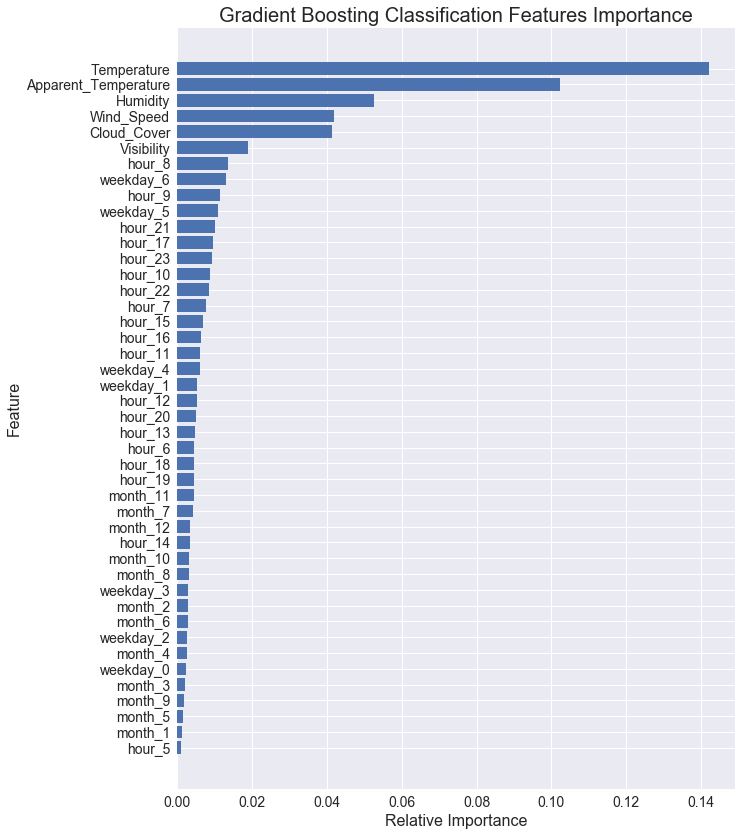

,Gradient Boosting Classification
Accuracy,0.817408
F1 (macro),0.817388
F1 (micro),0.817408
Precision (macro),0.817524
Precision (micro),0.817408
Recall (macro),0.817399
Recall (micro),0.817408


In [58]:
# Gradient Boosting Classifier
class_model = 'Gradient Boosting Classification'
#clf = GradientBoostingClassifier()
start = timer()
clf = GradientBoostingClassifier(n_estimators=150, max_features='auto', max_depth=None, random_state=0)
gbc = perform_classification(class_model, clf)
gbc_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format((end - start)))
gbc_et = get_execution_time_metrics(class_model, et)
plot_feature_importances(clf, class_model)
gbc.sort_index()

#### Multi-layer Perceptron Classification

In [59]:
# Multi-Layer Perceptron Classification
class_model = 'Multi-Layer Perception Classification'
start = timer()
clf = MLPClassifier(random_state=0)
mlp = perform_classification(class_model, clf)
mlp_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format((end - start)))
mlp_et = get_execution_time_metrics(class_model, et)
mlp.sort_index()

Multi-Layer Perception Classification 

Accuracy on training set: 0.869
Accuracy on test set: 0.876

Confusion Matrix:
[[943 115]
 [148 908]]

Classification Report:
             precision    recall  f1-score   support

          0       0.86      0.89      0.88      1058
          1       0.89      0.86      0.87      1056

avg / total       0.88      0.88      0.88      2114

Cross-validation scores:
[ 0.87028101  0.87397105  0.86971331  0.86290094  0.87482259]
Cross-validation accuracy: 0.87 (+/- 0.01) @ 95% CI

Execution Time (sec): 9.781


,Multi-Layer Perception Classification
Accuracy,0.875591
F1 (macro),0.875557
F1 (micro),0.875591
Precision (macro),0.875965
Precision (micro),0.875591
Recall (macro),0.875576
Recall (micro),0.875591


## Classification Summary with Categorical Feature Set

In [60]:
class_metrics = pd.concat([lin_reg, dtc, rfc, etc, nbg, knn, gbc, mlp] , axis=1)

In [61]:
xv_metrics = pd.concat([lin_reg_xv, dtc_xv, rfc_xv, etc_xv, nbg_xv, knn_xv, gbc_xv, mlp_xv], axis = 1)

In [62]:
et_metrics = pd.concat([lin_reg_et, dtc_et, rfc_et, etc_et, nbg_et, knn_et, gbc_et, mlp_et], axis = 1)

In [63]:
final_metrics = pd.concat([class_metrics, xv_metrics, et_metrics])
print("Classification Summary with Categorical Features\n")
final_metrics

Classification Summary with Categorical Features



,Logistic Classification,Decision Tree Classification,Random Forest Classification,Extra Trees Classification,Naive Bayes Classification,Nearest Neighbors Classification,Gradient Boosting Classification,Multi-Layer Perception Classification
Accuracy,0.877010,0.811258,0.856197,0.877010,0.756386,0.714286,0.817408,0.875591
F1 (macro),0.877009,0.811243,0.856088,0.876975,0.747293,0.703119,0.817388,0.875557
F1 (micro),0.877010,0.811258,0.856197,0.877010,0.756386,0.714286,0.817408,0.875591
Precision (macro),0.877030,0.811341,0.857210,0.877409,0.799952,0.751804,0.817524,0.875965
Precision (micro),0.877010,0.811258,0.856197,0.877010,0.756386,0.714286,0.817408,0.875591
Recall (macro),0.877014,0.811251,0.856172,0.876995,0.756566,0.714103,0.817399,0.875576
Recall (micro),0.877010,0.811258,0.856197,0.877010,0.756386,0.714286,0.817408,0.875591
Cross Validation,0.858643,0.804258,0.856145,0.867045,0.740562,0.721885,0.799319,0.870338
Execution Time (sec),10.791598,0.317235,4.023082,3.425960,0.175422,0.994537,48.096231,9.780759


The Extra Trees model attained the highest accuracy in classifying the four classes. The Naïve Bayes model performed the poorest.

## 3. Modeling - Numerical Feature Set

In [64]:
data = data[['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour', 'Temperature', 
           'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility', 'Class_Label']]

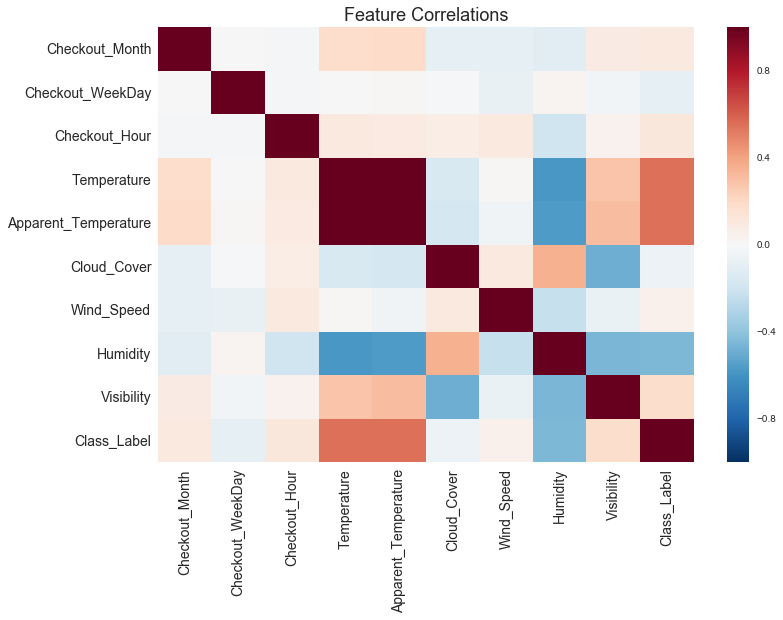

In [65]:
plt.figure(figsize=(12,8))
ax = sns.heatmap(data.corr())
plt.title("Feature Correlations", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7046 entries, 0 to 8758
Data columns (total 10 columns):
Checkout_Month          7046 non-null int32
Checkout_WeekDay        7046 non-null int32
Checkout_Hour           7046 non-null int64
Temperature             7046 non-null float64
Apparent_Temperature    7046 non-null float64
Cloud_Cover             7046 non-null float64
Wind_Speed              7046 non-null float64
Humidity                7046 non-null float64
Visibility              7046 non-null float64
Class_Label             7046 non-null int64
dtypes: float64(6), int32(2), int64(2)
memory usage: 550.5 KB


In [67]:
array = data.values
X = array[:,0:8]
y = array[:,8]

In [68]:
features = ['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour',  
            'Temperature', 'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility']
X = data[features]
y = data["Class_Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [69]:
def plot_feature_importances(model, plot_title):
    n_features = X.shape[1]
    plt.figure(figsize=(10,6))
    feature_importance = model.feature_importances_
    features_list = features
    feature_importance, features_list = zip(*sorted(zip(feature_importance, features_list)))
    plt.barh(range(len(features_list)), feature_importance, align='center')
    plt.xticks(fontsize=14)
    plt.yticks(np.arange(len(features_list)), features_list, fontsize=14)
    plt.xlabel('Relative Importance', fontsize=16)
    plt.ylabel('Feature', fontsize=16)
    plt.title(plot_title + ' Features Importance', fontsize=20)
    plt.show()

#### Decision Tree Classification

Decision Tree Classification 

Accuracy on training set: 1.000
Accuracy on test set: 0.846

Confusion Matrix:
[[898 160]
 [166 890]]

Classification Report:
             precision    recall  f1-score   support

          0       0.84      0.85      0.85      1058
          1       0.85      0.84      0.85      1056

avg / total       0.85      0.85      0.85      2114

Cross-validation scores:
[ 0.83707068  0.82940676  0.82997445  0.83735453  0.82628442]
Cross-validation accuracy: 0.83 (+/- 0.01) @ 95% CI

Execution Time (sec): 0.302


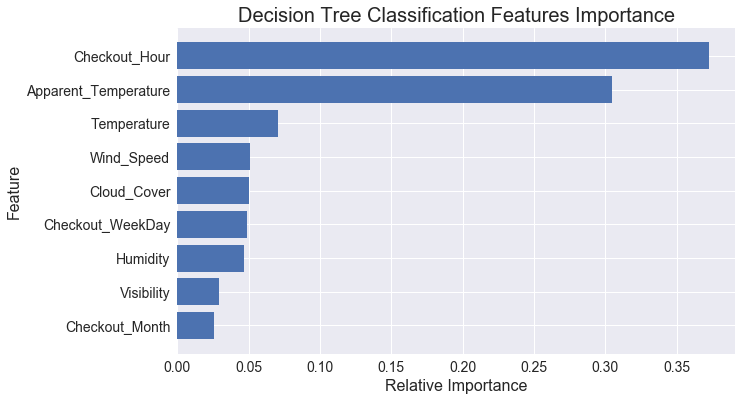

,Decision Tree Classification
Accuracy,0.845790
F1 (macro),0.845788
F1 (micro),0.845790
Precision (macro),0.845802
Precision (micro),0.845790
Recall (macro),0.845787
Recall (micro),0.845790


In [70]:
# Decision Tree Classifier
class_model = 'Decision Tree Classification'
start = timer()
clf = DecisionTreeClassifier(random_state=0)
dtc = perform_classification(class_model, clf)
dtc_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format(et))
dtc_et = get_execution_time_metrics(class_model, et)
plot_feature_importances(clf, class_model)
dtc.sort_index()

#### Linear (Logistic Regression) Classification

In [71]:
# logistic regression
class_model = 'Logistic Classification'
start = timer()
#clf = linear_model.LogisticRegression(random_state=0)
clf = linear_model.LogisticRegression(C=1.0, solver='lbfgs', random_state=0, multi_class='ovr', n_jobs=-1)
lin_reg = perform_classification(class_model, clf)
lin_reg_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format((end - start)))
lin_reg_et = get_execution_time_metrics(class_model, et)
lin_reg.sort_index()

Logistic Classification 

Accuracy on training set: 0.766
Accuracy on test set: 0.773

Confusion Matrix:
[[810 248]
 [232 824]]

Classification Report:
             precision    recall  f1-score   support

          0       0.78      0.77      0.77      1058
          1       0.77      0.78      0.77      1056

avg / total       0.77      0.77      0.77      2114

Cross-validation scores:
[ 0.76923077  0.76951462  0.76156685  0.77803009  0.78001703]
Cross-validation accuracy: 0.77 (+/- 0.01) @ 95% CI

Execution Time (sec): 9.677


,Logistic Classification
Accuracy,0.772942
F1 (macro),0.772932
F1 (micro),0.772942
Precision (macro),0.773004
Precision (micro),0.772942
Recall (macro),0.772949
Recall (micro),0.772942


#### Random Forest Classification

Random Forest Classification 

Accuracy on training set: 1.000
Accuracy on test set: 0.878

Confusion Matrix:
[[944 114]
 [143 913]]

Classification Report:
             precision    recall  f1-score   support

          0       0.87      0.89      0.88      1058
          1       0.89      0.86      0.88      1056

avg / total       0.88      0.88      0.88      2114

Cross-validation scores:
[ 0.86772637  0.88049957  0.87567414  0.87851263  0.86942946]
Cross-validation accuracy: 0.87 (+/- 0.01) @ 95% CI

Execution Time (sec): 3.973


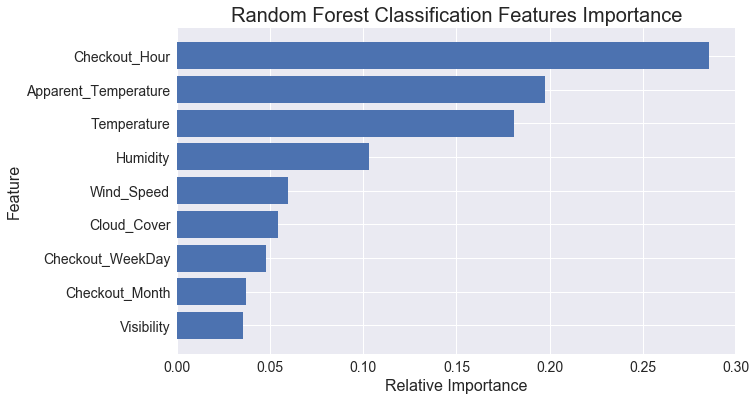

,Random Forest Classification
Accuracy,0.878430
F1 (macro),0.878403
F1 (micro),0.878430
Precision (macro),0.878721
Precision (micro),0.878430
Recall (macro),0.878416
Recall (micro),0.878430


In [72]:
# Random Forest Classifier
class_model = 'Random Forest Classification'
start = timer() 
clf = RandomForestClassifier(n_estimators=150, max_features='auto', max_depth=None, random_state=0, n_jobs=-1)
rfc = perform_classification(class_model, clf)
rfc_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format((end - start)))
rfc_et = get_execution_time_metrics(class_model, et)
plot_feature_importances(clf, class_model)
rfc.sort_index()

#### Extra Trees Classification

Extra Trees Classification 

Accuracy on training set: 1.000
Accuracy on test set: 0.872

Confusion Matrix:
[[950 108]
 [162 894]]

Classification Report:
             precision    recall  f1-score   support

          0       0.85      0.90      0.88      1058
          1       0.89      0.85      0.87      1056

avg / total       0.87      0.87      0.87      2114

Cross-validation scores:
[ 0.86375248  0.87964803  0.87028101  0.86914561  0.87226795]
Cross-validation accuracy: 0.87 (+/- 0.01) @ 95% CI

Execution Time (sec): 3.246


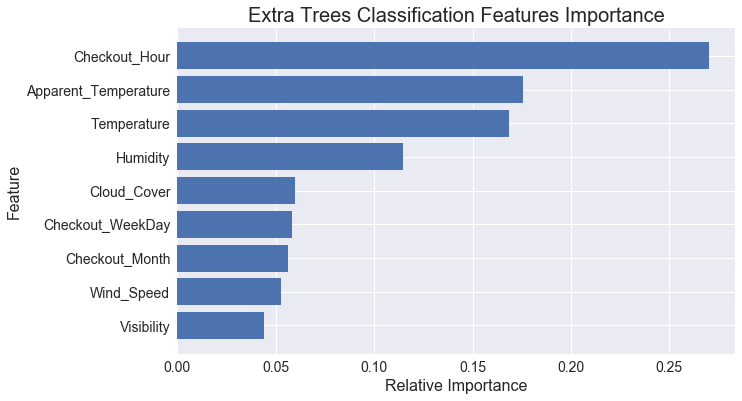

,Extra Trees Classification
Accuracy,0.872280
F1 (macro),0.872190
F1 (micro),0.872280
Precision (macro),0.873266
Precision (micro),0.872280
Recall (macro),0.872256
Recall (micro),0.872280


In [73]:
# Extra Trees Classifier
class_model = 'Extra Trees Classification'
start = timer() 
clf = ExtraTreesClassifier(n_estimators=150, max_features='auto', max_depth=None, random_state=0, n_jobs=-1)
etc = perform_classification(class_model, clf)
etc_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format((end - start)))
etc_et = get_execution_time_metrics(class_model, et)
plot_feature_importances(clf, class_model)
etc.sort_index()

#### Naive Bayes Classification

In [74]:
# Naive Bayes Classifier
class_model = 'Naive Bayes Classification'
start = timer()
clf = naive_bayes.GaussianNB()
nbg = perform_classification(class_model, clf)
nbg_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format((end - start)))
nbg_et = get_execution_time_metrics(class_model, et)
nbg.sort_index()

Naive Bayes Classification 

Accuracy on training set: 0.766
Accuracy on test set: 0.772

Confusion Matrix:
[[727 331]
 [152 904]]

Classification Report:
             precision    recall  f1-score   support

          0       0.83      0.69      0.75      1058
          1       0.73      0.86      0.79      1056

avg / total       0.78      0.77      0.77      2114

Cross-validation scores:
[ 0.7734885   0.75730911  0.77178541  0.76781152  0.75560602]
Cross-validation accuracy: 0.77 (+/- 0.01) @ 95% CI

Execution Time (sec): 0.107


,Naive Bayes Classification
Accuracy,0.771523
F1 (macro),0.769910
F1 (micro),0.771523
Precision (macro),0.779530
Precision (micro),0.771523
Recall (macro),0.771603
Recall (micro),0.771523


#### Nearest Neighbors Classification

In [75]:
# Nearest Neighbors Classifier
class_model = 'Nearest Neighbors Classification'
start = timer()
clf = KNeighborsClassifier(n_neighbors=2, n_jobs=-1)
knn = perform_classification(class_model, clf)
knn_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format((end - start)))
knn_et = get_execution_time_metrics(class_model, et)
knn.sort_index()

Nearest Neighbors Classification 

Accuracy on training set: 0.916
Accuracy on test set: 0.815

Confusion Matrix:
[[973  85]
 [306 750]]

Classification Report:
             precision    recall  f1-score   support

          0       0.76      0.92      0.83      1058
          1       0.90      0.71      0.79      1056

avg / total       0.83      0.82      0.81      2114

Cross-validation scores:
[ 0.82174283  0.82486517  0.81606585  0.82259438  0.82741981]
Cross-validation accuracy: 0.82 (+/- 0.01) @ 95% CI

Execution Time (sec): 0.954


,Nearest Neighbors Classification
Accuracy,0.815043
F1 (macro),0.812961
F1 (micro),0.815043
Precision (macro),0.829477
Precision (micro),0.815043
Recall (macro),0.814944
Recall (micro),0.815043


#### Gradient Boosting Classification

Gradient Boosting Classification 

Accuracy on training set: 1.000
Accuracy on test set: 0.852

Confusion Matrix:
[[910 148]
 [165 891]]

Classification Report:
             precision    recall  f1-score   support

          0       0.85      0.86      0.85      1058
          1       0.86      0.84      0.85      1056

avg / total       0.85      0.85      0.85      2114

Cross-validation scores:
[ 0.84587     0.84161226  0.84728924  0.8447346   0.83792223]
Cross-validation accuracy: 0.84 (+/- 0.01) @ 95% CI

Execution Time (sec): 20.226


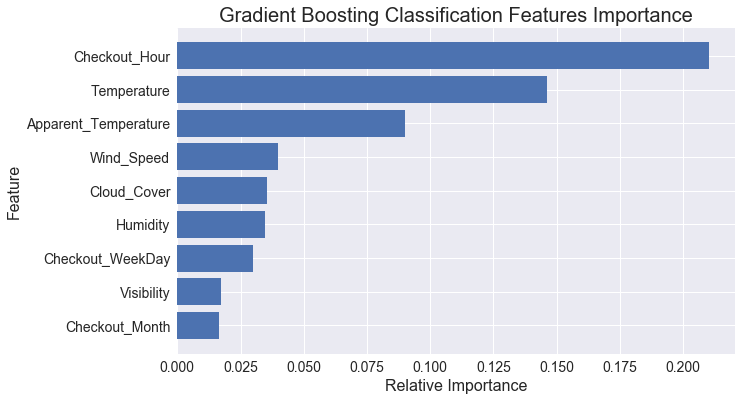

,Gradient Boosting Classification
Accuracy,0.851939
F1 (macro),0.851927
F1 (micro),0.851939
Precision (macro),0.852033
Precision (micro),0.851939
Recall (macro),0.851932
Recall (micro),0.851939


In [76]:
# Gradient Boosting Classifier
class_model = 'Gradient Boosting Classification'
#clf = GradientBoostingClassifier()
start = timer()
clf = GradientBoostingClassifier(n_estimators=150, max_features='auto', max_depth=None, random_state=0)
gbc = perform_classification(class_model, clf)
gbc_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format((end - start)))
gbc_et = get_execution_time_metrics(class_model, et)
plot_feature_importances(clf, class_model)
gbc.sort_index()

#### Multi-layer Perceptron Classification

In [77]:
# Multi-Layer Perceptron Classification
class_model = 'Multi-Layer Perception Classification'
start = timer()
clf = MLPClassifier(random_state=0)
mlp = perform_classification(class_model, clf)
mlp_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format((end - start)))
mlp_et = get_execution_time_metrics(class_model, et)
mlp.sort_index()

Multi-Layer Perception Classification 

Accuracy on training set: 0.854
Accuracy on test set: 0.868

Confusion Matrix:
[[934 124]
 [156 900]]

Classification Report:
             precision    recall  f1-score   support

          0       0.86      0.88      0.87      1058
          1       0.88      0.85      0.87      1056

avg / total       0.87      0.87      0.87      2114

Cross-validation scores:
[ 0.84899234  0.85665626  0.84359921  0.85580471  0.85835935]
Cross-validation accuracy: 0.85 (+/- 0.01) @ 95% CI

Execution Time (sec): 4.670


,Multi-Layer Perception Classification
Accuracy,0.867550
F1 (macro),0.867515
F1 (micro),0.867550
Precision (macro),0.867893
Precision (micro),0.867550
Recall (macro),0.867535
Recall (micro),0.867550


## Classification Summary with Numerical Feature Set

In [78]:
class_metrics = pd.concat([lin_reg, dtc, rfc, etc, nbg, knn, gbc, mlp] , axis=1)

In [79]:
xv_metrics = pd.concat([lin_reg_xv, dtc_xv, rfc_xv, etc_xv, nbg_xv, knn_xv, gbc_xv, mlp_xv], axis = 1)

In [80]:
et_metrics = pd.concat([lin_reg_et, dtc_et, rfc_et, etc_et, nbg_et, knn_et, gbc_et, mlp_et], axis = 1)

In [81]:
final_metrics = pd.concat([class_metrics, xv_metrics, et_metrics])
print("Classification Summary with Numerical Feature Set\n")
final_metrics

Classification Summary with Numerical Feature Set



,Logistic Classification,Decision Tree Classification,Random Forest Classification,Extra Trees Classification,Naive Bayes Classification,Nearest Neighbors Classification,Gradient Boosting Classification,Multi-Layer Perception Classification
Accuracy,0.772942,0.845790,0.878430,0.872280,0.771523,0.815043,0.851939,0.867550
F1 (macro),0.772932,0.845788,0.878403,0.872190,0.769910,0.812961,0.851927,0.867515
F1 (micro),0.772942,0.845790,0.878430,0.872280,0.771523,0.815043,0.851939,0.867550
Precision (macro),0.773004,0.845802,0.878721,0.873266,0.779530,0.829477,0.852033,0.867893
Precision (micro),0.772942,0.845790,0.878430,0.872280,0.771523,0.815043,0.851939,0.867550
Recall (macro),0.772949,0.845787,0.878416,0.872256,0.771603,0.814944,0.851932,0.867535
Recall (micro),0.772942,0.845790,0.878430,0.872280,0.771523,0.815043,0.851939,0.867550
Cross Validation,0.771672,0.832018,0.874368,0.871019,0.765200,0.822538,0.843486,0.852682
Execution Time (sec),9.676564,0.301543,3.972808,3.246149,0.106590,0.953759,20.225848,4.669855


## Test Random Forest Classifier on Unseen Samples

In [82]:
dUT = dUT[['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour', 'Temperature', 'Apparent_Temperature',
             'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility', 'Number_Of_Checkouts']]
features = ['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour',  
                 'Temperature', 'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility']
dUT['Class_Label'] = dUT['Number_Of_Checkouts'].map(lambda x: 0 if ((x >= 1) & (x <= 10)) 
                                                 else 1)
pred_X = dUT[features]
act_y = dUT['Class_Label']
pred_array = dUT.values
pred_X_array = pred_array[:,0:9]
act_y_array = pred_array[:,10].astype(int)

rfc = RandomForestClassifier(n_estimators=150, max_features='auto', max_depth=None, random_state=0, n_jobs=-1)
rfc.fit(X, y)
pred = rfc.predict(pred_X_array)
print('predicted =', pred)
print('actual =   ', act_y_array)

predicted = [1 1 0 1 1 1 1 0 0 0]
actual =    [1 1 0 1 1 1 0 0 0 0]


## 4. Summary

The Random Forest and the Extra Trees classifers achieved the highest accuracy and the Naïve Bayes the lowest.